In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gc
import sys
import math

from pandas.io.json import json_normalize
from datetime import datetime

import os
print(os.listdir("../input"))

In [ ]:
gc.enable()

features = ['channelGrouping', 'date', 'fullVisitorId', 'visitId',\
       'visitNumber', 'visitStartTime', 'device.browser',\
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',\
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',\
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',\
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',\
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',\
       'trafficSource.adContent', 'trafficSource.campaign',\
       'trafficSource.isTrueDirect', 'trafficSource.keyword',\
       'trafficSource.medium', 'trafficSource.referralPath',\
       'trafficSource.source', 'customDimensions']

def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    ans = pd.DataFrame()
    dfs = pd.read_csv(csv_path, sep=',',
            converters={column: json.loads for column in JSON_COLUMNS}, 
            dtype={'fullVisitorId': 'str'}, # Important!!
            chunksize=100000)
    for df in dfs:
        df.reset_index(drop=True, inplace=True)
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

        #print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
        use_df = df[features]
        del df
        gc.collect()
        ans = pd.concat([ans, use_df], axis=0).reset_index(drop=True)
        #print(ans.shape)
    return ans

In [ ]:
%%time
train = load_df('../input/train_v2.csv')
test = load_df('../input/test_v2.csv')

print('train date:', min(train['date']), 'to', max(train['date']))
print('test date:', min(test['date']), 'to', max(test['date']))

In [25]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,0.0,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1,1,1,0.0,NaN,(not set),NaN,water bottle,organic,NaN,google,"[{'index': '4', 'value': 'EMEA'}]"
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,0.0,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,2,NaN,2,0.0,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,"[{'index': '4', 'value': 'North America'}]"
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,1.0,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,NaN,2,1,2,0.0,NaN,(not set),True,NaN,(none),NaN,(direct),"[{'index': '4', 'value': 'North America'}]"
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,0.0,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,NaN,2,1,2,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google,"[{'index': '4', 'value': 'EMEA'}]"
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,0.0,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,NaN,2,1,2,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google,"[{'index': '4', 'value': 'Central America'}]"


In [29]:
test.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions
0,Organic Search,20180511,7460955084541987166,1526099341,2,1526099341,Chrome,mobile,1.0,Android,(not set),Asia,India,(not set),unknown.unknown,Delhi,Southern Asia,NaN,4,NaN,3,NaN,(not set),(not set),True,(not provided),organic,(not set),google,"[{'index': '4', 'value': 'APAC'}]"
1,Direct,20180511,460252456180441002,1526064483,166,1526064483,Chrome,desktop,0.0,Macintosh,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,4,NaN,3,NaN,(not set),(not set),True,(not set),(none),(not set),(direct),"[{'index': '4', 'value': 'North America'}]"
2,Organic Search,20180511,3461808543879602873,1526067157,2,1526067157,Chrome,desktop,0.0,Chrome OS,not available in demo dataset,Americas,United States,not available in demo dataset,onlinecomputerworks.com,not available in demo dataset,Northern America,NaN,4,NaN,3,NaN,(not set),(not set),True,(not provided),organic,(not set),google,"[{'index': '4', 'value': 'North America'}]"
3,Direct,20180511,975129477712150630,1526107551,4,1526107551,Chrome,mobile,1.0,iOS,Houston,Americas,United States,Houston TX,(not set),Texas,Northern America,NaN,5,NaN,4,NaN,(not set),(not set),True,(not set),(none),(not set),(direct),"[{'index': '4', 'value': 'North America'}]"
4,Organic Search,20180511,8381672768065729990,1526060254,1,1526060254,Internet Explorer,tablet,1.0,Windows,Irvine,Americas,United States,Los Angeles CA,com,California,Northern America,NaN,5,1,4,NaN,(not set),(not set),NaN,(not provided),organic,(not set),google,"[{'index': '4', 'value': 'North America'}]"


In [ ]:
train['totals.transactionRevenue'].describe()

In [ ]:
# Thanks and credited to https://www.kaggle.com/gemartin
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [ ]:
# only train feature
for c in train.columns.values:
    if c not in test.columns.values: print(c)

In [ ]:
train['totals.transactionRevenue'].fillna(0, inplace=True)
train['totals.transactionRevenue'] = np.log1p(train['totals.transactionRevenue'].astype(float))
print(train['totals.transactionRevenue'].describe())

In [ ]:
test['totals.transactionRevenue'] = np.nan

# 

In [ ]:
all_data = train.append(test, sort=False).reset_index(drop=True)

In [ ]:
print(all_data.info())

In [ ]:
null_cnt = train.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])

In [ ]:
# fillna object feature
for col in ['trafficSource.keyword',
            'trafficSource.referralPath',
            'trafficSource.adContent']:
    all_data[col].fillna('unknown', inplace=True)

# fillna numeric feature
all_data['totals.pageviews'].fillna(1, inplace=True)
all_data['totals.newVisits'].fillna(0, inplace=True)
all_data['totals.bounces'].fillna(0, inplace=True)
all_data['totals.pageviews'] = all_data['totals.pageviews'].astype(int)
all_data['totals.newVisits'] = all_data['totals.newVisits'].astype(int)
all_data['totals.bounces'] = all_data['totals.bounces'].astype(int)

# fillna boolean feature
all_data['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [ ]:
all_data.describe()

In [ ]:
# drop constant column
constant_column = [col for col in all_data.columns if all_data[col].nunique() == 1]
#for c in constant_column:
#    print(c + ':', train[c].unique())

print('drop columns:', constant_column)
all_data.drop(constant_column, axis=1, inplace=True)

In [28]:
# pickup any visitor
all_data[all_data['fullVisitorId'] == '8934116514970143966'].sort_values(by='visitNumber')[
    ['date','visitId','visitNumber','totals.hits','totals.pageviews','totals.transactionRevenue']]

,date,visitId,visitNumber,totals.hits,totals.pageviews,totals.transactionRevenue
664454,20170829,1504068634,1,25,18,0.000000
422426,20170922,1506112800,3,2,2,0.000000
800474,20170926,1506435456,4,30,23,16.156354
2868,20171016,1508160211,5,2,2,0.000000
1,20171016,1508176307,6,2,2,0.000000
7755,20171130,1512072970,7,3,3,0.000000
1183546,20171217,1513517517,8,18,13,16.587474


In [30]:
train_rev = train[train['totals.transactionRevenue'] > 0].copy()
print(len(train_rev))
train_rev.head()

18514


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions
433,Organic Search,20171016,9549826748224805897,1508200705,4,1508200705,Chrome,desktop,0.0,Macintosh,New York,Americas,United States,New York NY,(not set),New York,Northern America,NaN,9,NaN,9,16.536148,NaN,(not set),True,(not provided),organic,NaN,google,"[{'index': '4', 'value': 'North America'}]"
550,Referral,20171016,3700714855829972615,1508192636,11,1508192636,Chrome,desktop,0.0,Windows,Irvine,Americas,United States,Los Angeles CA,(not set),California,Northern America,NaN,15,NaN,12,15.894952,NaN,(not set),NaN,NaN,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"
555,Organic Search,20171016,1572225825161580042,1508162218,6,1508162218,Safari,mobile,1.0,iOS,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,purechat.com,California,Northern America,NaN,15,NaN,15,17.863811,NaN,(not set),True,(not provided),organic,NaN,google,"[{'index': '4', 'value': 'North America'}]"
597,Referral,20171016,7187192533100162289,1508189401,17,1508189401,Chrome,desktop,0.0,Macintosh,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,18,NaN,16,16.718579,NaN,(not set),True,NaN,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"
619,Referral,20171016,7889233516776348524,1508190484,1,1508190484,Chrome,desktop,0.0,Macintosh,New York,Americas,United States,New York NY,(not set),New York,Northern America,NaN,21,1,20,16.325923,NaN,(not set),NaN,NaN,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"


In [31]:
def plotCategoryRateBar(a, b, colName, topN=np.nan):
    if topN == topN: # isNotNan
        vals = b[colName].value_counts()[:topN]
        subA = a.loc[a[colName].isin(vals.index.values), colName]
        df = pd.DataFrame({'All':subA.value_counts() / len(a), 'Revenue':vals / len(b)})
    else:
        df = pd.DataFrame({'All':a[colName].value_counts() / len(a), 'Revenue':b[colName].value_counts() / len(b)})
    df.sort_values('Revenue').plot.barh(colormap='jet')

## customDimensions

unique customDimensions count: 6


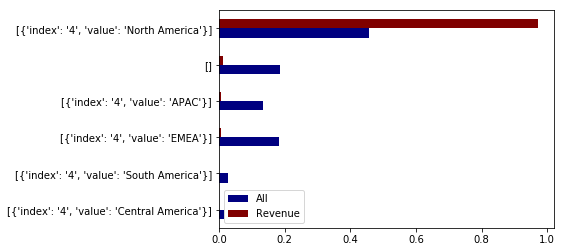

In [32]:
print('unique customDimensions count:', train['customDimensions'].nunique())
plotCategoryRateBar(all_data, train_rev, 'customDimensions')

## date

In [ ]:
format_str = '%Y%m%d'
all_data['formated_date'] = all_data['date'].apply(lambda x: datetime.strptime(str(x), format_str))
all_data['_year'] = all_data['formated_date'].apply(lambda x:x.year)
all_data['_month'] = all_data['formated_date'].apply(lambda x:x.month)
all_data['_quarterMonth'] = all_data['formated_date'].apply(lambda x:x.day//8)
all_data['_day'] = all_data['formated_date'].apply(lambda x:x.day)
all_data['_weekday'] = all_data['formated_date'].apply(lambda x:x.weekday())

all_data.drop(['date','formated_date'], axis=1, inplace=True)

## channelGrouping
* The channel via which the user came to the Store.

In [ ]:
plotCategoryRateBar(all_data, train_rev, 'channelGrouping')

## fullVisitorId
* A unique identifier for each user of the Google Merchandise Store.

## visitId
* An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user.   
For a completely unique ID, you should use a combination of fullVisitorId and visitId.

## newVisits


In [ ]:
print('train all:', len(train))
print('train unique fullVisitorId:', train['fullVisitorId'].nunique())
print('train unique visitId:', train['visitId'].nunique())
print('-' * 30)
print('test all:', len(test))
print('test unique fullVisitorId:', test['fullVisitorId'].nunique())
print('test unique visitId:', test['visitId'].nunique())

#print('common fullVisitorId:', len(pd.merge(train, test, how='inner', on='fullVisitorId'))) # 183434

In [ ]:
print(all_data['visitNumber'].value_counts()[:5])
print('-' * 30)
print(all_data['totals.newVisits'].value_counts())
print('-' * 30)
print(all_data['totals.bounces'].value_counts())

In [ ]:
#maxVisitNumber = max(all_data['visitNumber'])
#fvid = all_data[all_data['visitNumber'] == maxVisitNumber]['fullVisitorId']
#all_data[all_data['fullVisitorId'] == fvid.values[0]].sort_values(by='visitNumber')

In [ ]:
all_data['_visitStartHour'] = all_data['visitStartTime'].apply(
    lambda x: str(datetime.fromtimestamp(x).hour))

## device

In [ ]:
print('unique browser count:', train['device.browser'].nunique())
plotCategoryRateBar(all_data, train_rev, 'device.browser', 10)

In [ ]:
pd.crosstab(all_data['device.deviceCategory'], all_data['device.isMobile'], margins=False)

all_data['isMobile'] = True
all_data.loc[all_data['device.deviceCategory'] == 'desktop', 'isMobile'] = False

In [ ]:
print('unique operatingSystem count:', train['device.operatingSystem'].nunique())
plotCategoryRateBar(all_data, train_rev, 'device.operatingSystem', 10)

## geoNetwork

In [ ]:
print('unique geoNetwork.city count:', train['geoNetwork.city'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.city', 10)

In [ ]:
print('unique geoNetwork.region count:', train['geoNetwork.region'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.region', 10)

In [ ]:
print('unique geoNetwork.subContinent count:', train['geoNetwork.subContinent'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.subContinent', 10)

In [ ]:
print('unique geoNetwork.continent count:', train['geoNetwork.continent'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.continent')

In [ ]:
print('unique geoNetwork.metro count:', train['geoNetwork.metro'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.metro', 10)

In [ ]:
print('unique geoNetwork.networkDomain count:', train['geoNetwork.networkDomain'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.networkDomain', 10)

## totals

In [ ]:
print(all_data['totals.hits'].value_counts()[:10])

all_data['totals.hits'] = all_data['totals.hits'].astype(int)

In [ ]:
print(all_data['totals.pageviews'].value_counts()[:10])

all_data['totals.pageviews'] = all_data['totals.pageviews'].astype(int)

In [ ]:
#print(all_data['totals.visits'].value_counts())

## trafficSource

In [ ]:
print('unique trafficSource.adContent count:', train['trafficSource.adContent'].nunique())

plotCategoryRateBar(all_data, train_rev, 'trafficSource.adContent', 10)

all_data['_adContentGMC'] = (all_data['trafficSource.adContent'] == 'Google Merchandise Collection').astype(np.uint8)

In [ ]:
print('unique trafficSource.campaign count:', train['trafficSource.campaign'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.campaign', 10)

all_data['_withCampaign'] = (all_data['trafficSource.campaign'] != '(not set)').astype(np.uint8)

In [ ]:
print(all_data['trafficSource.isTrueDirect'].value_counts())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.isTrueDirect')

In [ ]:
print('unique trafficSource.keyword count:', train['trafficSource.keyword'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.keyword', 10)

In [ ]:
print('unique trafficSource.medium count:', train['trafficSource.medium'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.medium')

In [ ]:
print('unique trafficSource.referralPath count:', train['trafficSource.referralPath'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.referralPath', 10)

all_data['_referralRoot'] = (all_data['trafficSource.referralPath'] == '/').astype(np.uint8)

In [ ]:
print('unique trafficSource.source count:', train['trafficSource.source'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.source', 10)

all_data['_sourceGpmall'] = (all_data['trafficSource.source'] == 'mall.googleplex.com').astype(np.uint8)

## Aggregate

In [ ]:
_='''
'''
all_data['_meanHitsPerDay'] = all_data.groupby(['_day'])['totals.hits'].transform('mean')
all_data['_meanHitsPerWeekday'] = all_data.groupby(['_weekday'])['totals.hits'].transform('mean')
all_data['_meanHitsPerMonth'] = all_data.groupby(['_month'])['totals.hits'].transform('mean')
all_data['_sumHitsPerDay'] = all_data.groupby(['_day'])['totals.hits'].transform('sum')
all_data['_sumHitsPerWeekday'] = all_data.groupby(['_weekday'])['totals.hits'].transform('sum')
all_data['_sumHitsPerMonth'] = all_data.groupby(['_month'])['totals.hits'].transform('sum')

for feature in ['totals.hits', 'totals.pageviews']:
    info = all_data.groupby('fullVisitorId')[feature].mean()
    all_data['_usermean_' + feature] = all_data.fullVisitorId.map(info)
    
for feature in ['visitNumber']:
    info = all_data.groupby('fullVisitorId')[feature].max()
    all_data['_usermax_' + feature] = all_data.fullVisitorId.map(info)

del info

In [ ]:
all_data['_source.country'] = all_data['trafficSource.source'] + '_' + all_data['geoNetwork.country']
all_data['_campaign.medium'] = all_data['trafficSource.campaign'] + '_' + all_data['trafficSource.medium']
all_data['_browser.category'] = all_data['device.browser'] + '_' + all_data['device.deviceCategory']
all_data['_browser.os'] = all_data['device.browser'] + '_' + all_data['device.operatingSystem']